In [1]:
using DifferentialEquations
using OrdinaryDiffEq
using DiffEqBase
using Sundials
using ODEInterfaceDiffEq
using Plots
using Measures
using CSV
using DataFrames
# using Turing
# using MCMCChains
using EasyFit
using StatsPlots
using LinearAlgebra
using Random
using Distributions
using LsqFit
using BlackBoxOptim
using LaTeXStrings
using JLD2
using BlackBoxOptim: num_func_evals
using LatinHypercubeSampling

# Load Model Functions

In [2]:
include("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\ModelFunctionsAll.jl")

ObjectFunctMERP (generic function with 1 method)

# Load Data and Pyruvate T1s

In [3]:
global dat32mM = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ProcessedData\\4Mil_Dat.csv", DataFrame));
global dat128mM = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ProcessedData\\4Mil_12-8mMPyr_Dat.csv", DataFrame));

global datT1 = Matrix(CSV.read("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\ProcessedData\\T1s.csv", DataFrame));

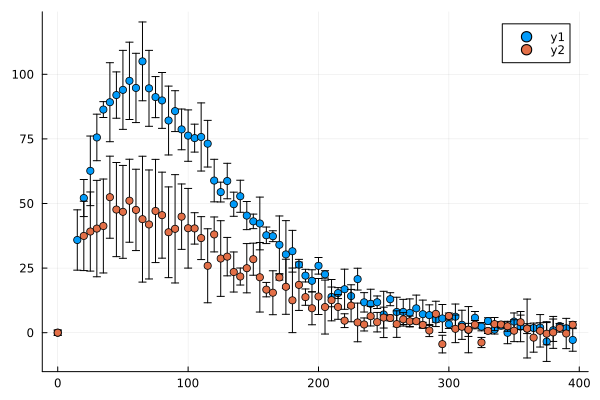

In [5]:
scatter(dat32mM[:,1], dat32mM[:,4], yerror=dat32mM[:,5])
scatter!(dat128mM[:,1], dat128mM[:,4], yerror=dat128mM[:,5])

# Define Models

In [6]:
# Michaelis Menten

function PyruvateHP_CellsMM!(du, u, p, t)

    Pout, Php, Xhp = u;
    Vm, Km, T1_X, T1_P, kin = p;


    du[1] = dPout = - (Pout*kin) - (Pout/T1_P)
    du[2] = dPhp = (Pout*kin) - ((Vm*Php)/(Km+Php)) - (Php/T1_P)
    du[3] = dXhp = ((Vm*Php)/(Km+Php)) - (Xhp/T1_X)
    

end

PyruvateHP_CellsMM! (generic function with 1 method)

In [7]:
function PyruvateHP_NMR_SolveAllMM(ts, pD, ivss, samps)

    if length(size(pD)) == 1
        pD = reshape(pD,size(pD)[1],1);
    end

    if size(pD)[2] != 6     
        pD = pD';
    end

    if length(ivss)/3 > 1
        if size(ivss)[2] != 3
            ivss = ivss';
        end
    end

    AllSolTest = zeros(length(samps), 3, length(pD[:,1])); # Simulation of the system observed
    AllSolTest_Off = Array{Any,1}(undef,length(pD[:,1])); # Simulation of the system before we obvserve it (considering time offset). First column is the time vector
    AllSolTest_Tog = Array{Any,1}(undef,length(pD[:,1])); # Previous two together. First column is the time vector. 


    
    for drawInd in collect(1:length(pD[:,1]))
        
        p = pD[drawInd,1:end-1];
        tau = pD[drawInd,end];
        
        if length(ivss)/3 > 1
            ivss2 = ivss[drawInd,:];
        else
            ivss2 = ivss;
        end
    
        # Account for the time offset
    
        
            prob_off = ODEProblem(PyruvateHP_CellsMM!,ivss2,(-tau, 0),p);
            part1_off = DifferentialEquations.solve(prob_off, CVODE_BDF(),reltol=1.0e-9,abstol=1.0e-9);
        
            ivss2 = part1_off.u[end];
        
            prob = ODEProblem(PyruvateHP_CellsMM!,ivss2,(ts[1], ts[end]),p);
            part1 = DifferentialEquations.solve(prob, CVODE_BDF(),reltol=1.0e-9,abstol=1.0e-9,saveat=1);
        
        
        AllSolTest[:,:,drawInd]
    
        tmp = zeros(length(part1_off.u), 3);
    
        
        

        for j in 1:3
            AllSolTest[:,j,drawInd] = [part1.u[i][j] for i in 1:length(part1.u)][samps.+1];
            tmp[:,j] = [part1_off.u[i][j] for i in 1:length(part1_off.u)];
        end

        AllSolTest_Off[drawInd] = hcat(part1_off.t, tmp);
        AllSolTest_Tog[drawInd] = vcat(AllSolTest_Off[drawInd][1:end-1, :], hcat(samps, AllSolTest[:,:,drawInd]));
        
        
        
    
    end

    return AllSolTest, AllSolTest_Off, AllSolTest_Tog

end

PyruvateHP_NMR_SolveAllMM (generic function with 1 method)

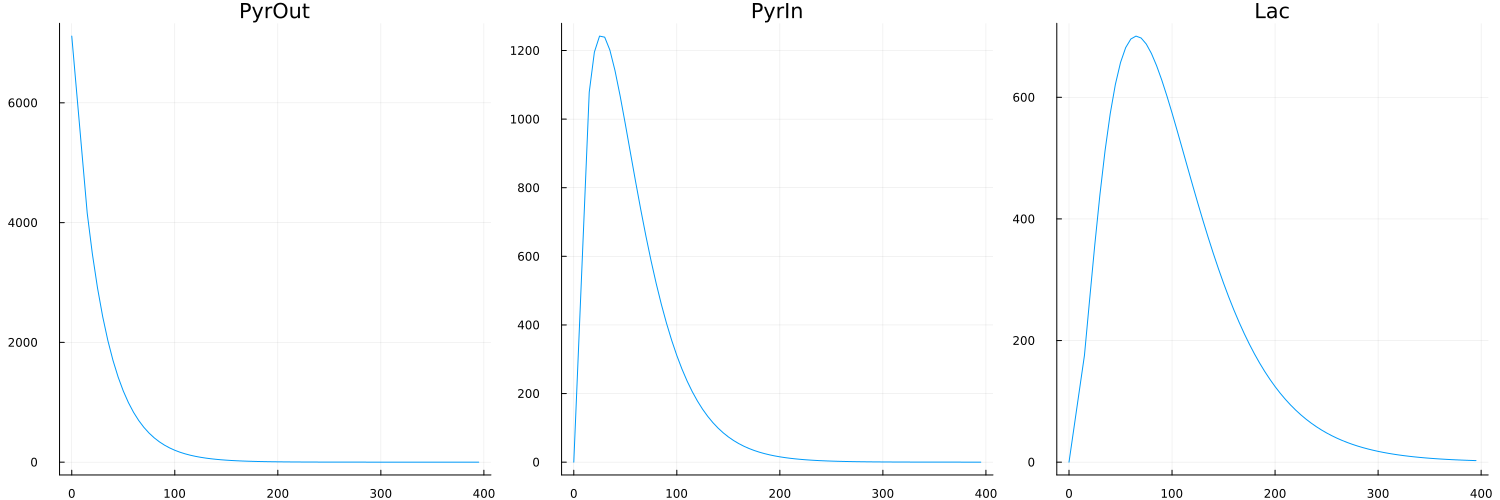

In [8]:
N = 4;

tsC2 = dat32mM[:,1]
ts = 0:tsC2[end];
ivss = [dat32mM[1,2],0, dat32mM[1,4]];
samps = convert.(Int, tsC2);
pp = [1e5, 2e7, 48, 55, 0.0044] #Vm, Km, T1_X, T1_P, kin
SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllMM(ts, vcat(vcat(pp[1]*N, pp[2], pp[3:4], pp[5].*N), 0), ivss, samps);

p1 = plot(tsC2, SimOnTime1[:,1,:], label = "", title = "PyrOut")
p2 = plot(tsC2, SimOnTime1[:,2,:], label = "", title = "PyrIn")
p3 = plot(tsC2, SimOnTime1[:,3,:], label = "", title = "Lac")

plot(p1, p2, p3, size=(1500,500), layout = (1,3))

# Repression

In [9]:
# Michaelis Menten Repression

function PyruvateHP_CellsMMR!(du, u, p, t)

    Pout, Php, Xhp = u;
    Vm, Km, T1_X, T1_P, kin, Ki = p;


    du[1] = dPout = - (Pout*kin) - (Pout/T1_P)
    du[2] = dPhp = (Pout*kin) - ((Vm*Php)/(Km+Php+((Php^2)/Ki))) - (Php/T1_P)
    du[3] = dXhp = ((Vm*Php)/(Km+Php+((Php^2)/Ki))) - (Xhp/T1_X)
    

    


    # du[2] = dPhp = (Pout*kin) - ((Vm*Php)/(Km+Php+((Php^2)/Ki))) - (Php/T1_P)
    # du[3] = dXhp = ((Vm*Php)/(Km+Php+((Php^2)/Ki))) - (Xhp/T1_X)


    # du[2] = dPhp = (Pout*kin) - ((Vm)/((1+(Km/Php))*(1+(Php/Ki)))) - (Php/T1_P)
    # du[3] = dXhp = ((Vm)/((1+(Km/Php))*(1+(Php/Ki)))) - (Xhp/T1_X)

    # du[2] = dPhp = (Pout*kin) - ((Vm*Php)/(Km*(1+(Php/Ki))+(Php))) - (Php/T1_P)
    # du[3] = dXhp = ((Vm*Php)/(Km*(1+(Php/Ki))+(Php))) - (Xhp/T1_X)

end

PyruvateHP_CellsMMR! (generic function with 1 method)

In [10]:
function PyruvateHP_NMR_SolveAllMMR(ts, pD, ivss, samps)

    if length(size(pD)) == 1
        pD = reshape(pD,size(pD)[1],1);
    end

    if size(pD)[2] != 7     
        pD = pD';
    end

    if length(ivss)/3 > 1
        if size(ivss)[2] != 3
            ivss = ivss';
        end
    end

    AllSolTest = zeros(length(samps), 3, length(pD[:,1])); # Simulation of the system observed
    AllSolTest_Off = Array{Any,1}(undef,length(pD[:,1])); # Simulation of the system before we obvserve it (considering time offset). First column is the time vector
    AllSolTest_Tog = Array{Any,1}(undef,length(pD[:,1])); # Previous two together. First column is the time vector. 


    
    for drawInd in collect(1:length(pD[:,1]))
        
        p = pD[drawInd,1:end-1];
        tau = pD[drawInd,end];
        
        if length(ivss)/3 > 1
            ivss2 = ivss[drawInd,:];
        else
            ivss2 = ivss;
        end
    
        # Account for the time offset
    
        
            prob_off = ODEProblem(PyruvateHP_CellsMMR!,ivss2,(-tau, 0),p);
            part1_off = DifferentialEquations.solve(prob_off, CVODE_BDF(),reltol=1.0e-9,abstol=1.0e-9);
        
            ivss2 = part1_off.u[end];
        
            prob = ODEProblem(PyruvateHP_CellsMMR!,ivss2,(ts[1], ts[end]),p);
            part1 = DifferentialEquations.solve(prob, CVODE_BDF(),reltol=1.0e-9,abstol=1.0e-9,saveat=1);
        
        
        AllSolTest[:,:,drawInd]
    
        tmp = zeros(length(part1_off.u), 3);
    
        
        

        for j in 1:3
            AllSolTest[:,j,drawInd] = [part1.u[i][j] for i in 1:length(part1.u)][samps.+1];
            tmp[:,j] = [part1_off.u[i][j] for i in 1:length(part1_off.u)];
        end

        AllSolTest_Off[drawInd] = hcat(part1_off.t, tmp);
        AllSolTest_Tog[drawInd] = vcat(AllSolTest_Off[drawInd][1:end-1, :], hcat(samps, AllSolTest[:,:,drawInd]));
        
        
        
    
    end

    return AllSolTest, AllSolTest_Off, AllSolTest_Tog

end

PyruvateHP_NMR_SolveAllMMR (generic function with 1 method)

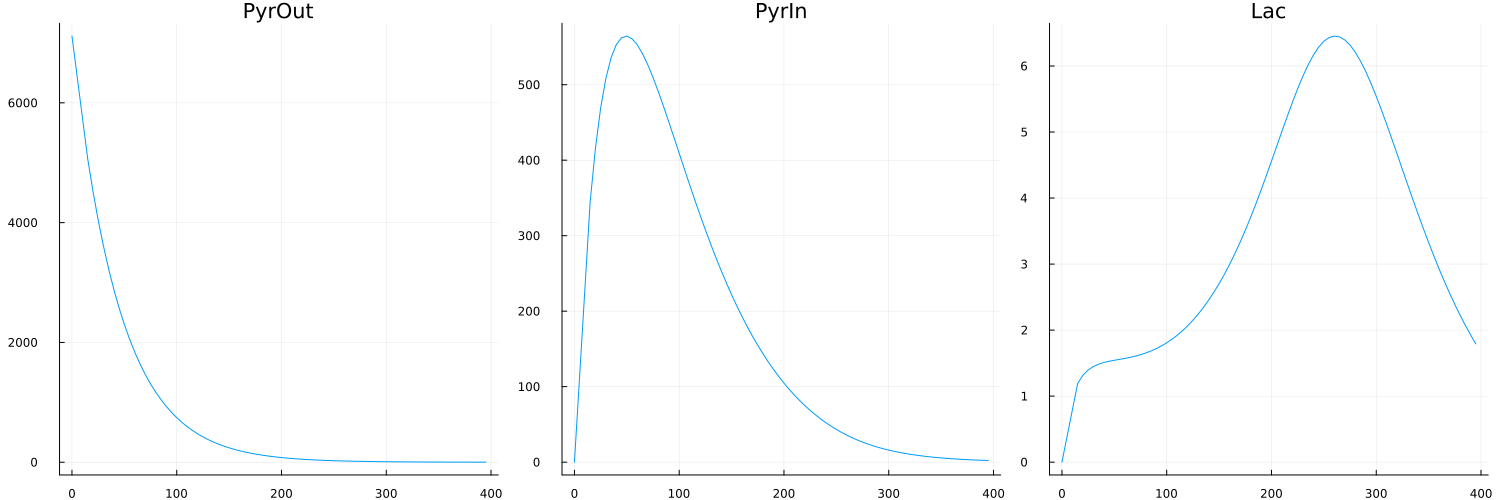

In [11]:
N = 4;

tsC2 = dat32mM[:,1]
ts = 0:tsC2[end];
ivss = [dat32mM[1,2],0, dat32mM[1,4]];
samps = convert.(Int, tsC2);
pp = [1e5, 2e7, 48, 55, 0.0044, 2e-4]
SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllMMR(ts, vcat(vcat(pp[1], pp[2], pp[3:4], pp[5], pp[6]), 0), ivss, samps);


p1 = plot(tsC2, SimOnTime1[:,1,:], label = "", title = "PyrOut")
p2 = plot(tsC2, SimOnTime1[:,2,:], label = "", title = "PyrIn")
p3 = plot(tsC2, SimOnTime1[:,3,:], label = "", title = "Lac")

plot(p1, p2, p3, size=(1500,500), layout = (1,3))

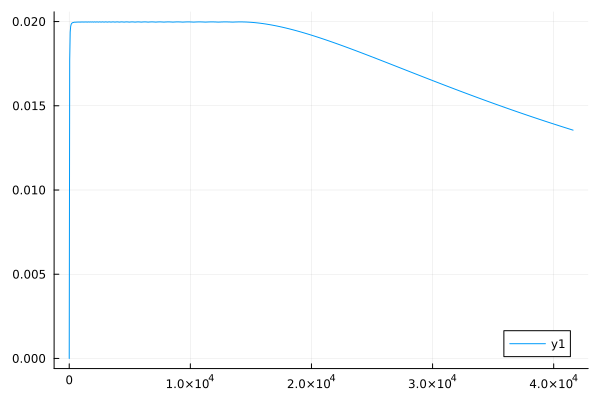

In [17]:
pyrs = collect(0:40:dat128mM[1,2]*1.2);
lacs = zeros(length(pyrs));

pp = [1e5, 2e9, 48, 55, 1000000, 2e-7]
cnt = 1;

for i in pyrs

    try
    N=4
    tsC2 = dat32mM[:,1]
    ts = 0:tsC2[end];
    ivss = [i, 0, dat32mM[1,4]];
    samps = convert.(Int, tsC2);
    SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllMMR(ts, vcat(vcat(pp), 0), ivss, samps);

    lacs[cnt] = maximum(SimOnTime1[:,3]);
    catch

    end
    cnt += 1;

end

plot(pyrs, lacs)


In [573]:
function ObjectFunctMEMMR(p)

    N = 4;

    # Define parameter vectors for each amount of cells (last parameter is a time delay, not used in here)
    pD2 = vcat(vcat(p[1]*N, p[2], p[3:4], p[5].*N, p[6]), 0);

    # Define time vector
    t2cor = dat32mM[:,1];
    t4cor = dat128mM[:,1];

    # Define equaly-spaced time vector
    ts1 = collect(0:t2cor[end]);
    ts2 = collect(0:t4cor[end]);

    # Define initial value for simulation (use of experimental mean)
    ivss1 = [dat32mM[1,2], 0, dat32mM[1,4]];
    ivss2 = [dat128mM[1,2], 0, dat128mM[1,4]];

    # Convert sampling vector to integer to extract correct elements from simulation
    samps1 = convert.(Int, t2cor);
    samps2 = convert.(Int, t4cor);

    # Simulate
    SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllMMR(ts1, pD2, ivss1, samps1);
    SimOnTime2, SimOffTime2, SimAll2  = PyruvateHP_NMR_SolveAllMMR(ts2, pD2, ivss2, samps2);

    # Use of log-likelihood as cost funtion: J_llk = sum(-1/2 * (log(2*pi) + log(std^2) + (sim-dat)^2/std^2))
    mm11 = sum((-1/2) .* (log(2*pi) .+ log.(dat32mM[:,3].^2) .+ (((SimOnTime1[:,1]+SimOnTime1[:,2]) .- dat32mM[:,2]).^2)./(dat32mM[:,3].^2)));
    mm12 = sum((-1/2) .* (log(2*pi) .+ log.(dat128mM[:,3].^2) .+ (((SimOnTime2[:,1]+SimOnTime2[:,2]) .- dat128mM[:,2]).^2)./(dat128mM[:,3].^2)));

    mm21 = sum((-1/2) .* (log(2*pi) .+ log.(dat32mM[:,5].^2) .+ ((SimOnTime1[:,3] .- dat32mM[:,4]).^2)./(dat32mM[:,5].^2)));
    mm22 = sum((-1/2) .* (log(2*pi) .+ log.(dat128mM[:,5].^2) .+ ((SimOnTime2[:,3] .- dat128mM[:,4]).^2)./(dat128mM[:,5].^2)));


    # obj = (mm21+mm22)*(mm11+mm12);
    obj = -(mm21+mm22);

    
    return(obj)

end

ObjectFunctMEMMR (generic function with 1 method)

In [574]:
function ObjectFunctMEMMR2(p)

    N = 4;

    # Define parameter vectors for each amount of cells (last parameter is a time delay, not used in here)
    pD2 = vcat(vcat(p[1]*N, p[2], p[3:4], p[5].*N, p[6]), 0);

    # Define time vector
    t2cor = dat32mM[:,1];
    t4cor = dat128mM[:,1];

    # Define equaly-spaced time vector
    ts1 = collect(0:t2cor[end]);
    ts2 = collect(0:t4cor[end]);

    # Define initial value for simulation (use of experimental mean)
    ivss1 = [dat32mM[1,2], 0, dat32mM[1,4]];
    ivss2 = [dat128mM[1,2], 0, dat128mM[1,4]];

    # Convert sampling vector to integer to extract correct elements from simulation
    samps1 = convert.(Int, t2cor);
    samps2 = convert.(Int, t4cor);

    obj = 0
    try
    # Simulate
        SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllMMR(ts1, pD2, ivss1, samps1);
        SimOnTime2, SimOffTime2, SimAll2  = PyruvateHP_NMR_SolveAllMMR(ts2, pD2, ivss2, samps2);

    

        mm21 = (maximum(SimOnTime1[:,3]) .- maximum(dat32mM[:,4])).^2
        mm22 = (maximum(SimOnTime2[:,3]) .- maximum(dat128mM[:,4])).^2

        obj = (mm21+mm22);
    catch
        obj = 1e100
    end
    
    return(obj)

end

ObjectFunctMEMMR2 (generic function with 1 method)

In [575]:
p = [0.012, 0.0064, 48, 55, 0.0044, 0.001];

ObjectFunctMEMMR(p)

3290.2837018282225

In [576]:
p = [0.012, 0.0064, 48, 55, 0.0044, 0.001];

ObjectFunctMEMMR2(p)

13773.682260101174

In [577]:
T1ss = vcat(datT1[1:5,2], datT1[7:11,2]);

In [583]:
Iters = 20;
CCsT = Array{Any}(undef,Iters);
FitsT = Array{Any}(undef,Iters);

In [592]:
Random.seed!(4879564)
plan = randomLHC(Iters,6)
initguessT = scaleLHC(plan,[(1e-300, 1e2), (1e-300, 1e5), (48, 48), (55, 55), (1e-300, 1e5), (1e-300, 1e4)])

20×6 Matrix{Float64}:
  73.6842    100000.0       48.0  55.0   73684.2         526.316
  31.5789     78947.4       48.0  55.0   26315.8        2105.26
  68.4211     73684.2       48.0  55.0   42105.3        2631.58
  78.9474      5263.16      48.0  55.0   21052.6        1578.95
  47.3684     47368.4       48.0  55.0   68421.1        3684.21
  42.1053     36842.1       48.0  55.0   47368.4        3157.89
 100.0        89473.7       48.0  55.0   63157.9        9473.68
  63.1579     31578.9       48.0  55.0   10526.3        1052.63
   5.26316    94736.8       48.0  55.0   89473.7        5263.16
  10.5263     42105.3       48.0  55.0   31578.9        5789.47
  15.7895     26315.8       48.0  55.0   36842.1        4736.84
   1.0e-300       1.0e-300  48.0  55.0   78947.4        7368.42
  84.2105     57894.7       48.0  55.0   57894.7        6842.11
  94.7368     15789.5       48.0  55.0   15789.5           1.0e-300
  36.8421     63157.9       48.0  55.0   94736.8        4210.53
  89.4737    

In [469]:
Threads.nthreads()

20

In [242]:
# i=1
# fitness_progress_history = Array{Tuple{Int, Float64},1}()
# callback = oc -> push!(fitness_progress_history, (num_func_evals(oc), best_fitness(oc)))

# resM = bboptimize(ObjectFunctMEMMR2; SearchRange = [(0, 1e2), (0, 1e5), (25, 100), (mean(T1ss)-std(T1ss)*4, mean(T1ss)+std(T1ss)*4), (0, 1e5), (0, 1e5)], 
#         MaxTime = 60*0.2, method = :adaptive_de_rand_1_bin, 
#         CallbackFunction = callback, CallbackInterval = 0.0)

# CCsT[i] = fitness_progress_history;
# FitsT[i] = resM;

In [470]:
# i=1
# fitness_progress_history = Array{Tuple{Int, Float64},1}()
# callback = oc -> push!(fitness_progress_history, (num_func_evals(oc), best_fitness(oc)))

# resM = bboptimize(ObjectFunctMEMMR2; SearchRange = [(0, 1e2), (0, 1e5), (48, 48), (55, 55), (0, 1e5), (1e-300, 1e4)], 
#         MaxTime = 60*0.4, method = :adaptive_de_rand_1_bin, 
#         CallbackFunction = callback, CallbackInterval = 0.0)

# CCsT[i] = fitness_progress_history;
# FitsT[i] = resM;

In [595]:
Threads.@threads for i in 1:Iters
    fitness_progress_history = Array{Tuple{Int, Float64},1}()
    callback = oc -> push!(fitness_progress_history, (num_func_evals(oc), best_fitness(oc)))

    resM = bboptimize(ObjectFunctMEMMR, initguessT[i,:]; SearchRange = [(0, 1e2), (0, 1e5), (48, 48), (55, 55), (0, 1e5), (1e-300, 1e4)], 
            MaxTime = 60*0.6, method = :adaptive_de_rand_1_bin, 
            CallbackFunction = callback, CallbackInterval = 0.0)

    CCsT[i] = fitness_progress_history;
    FitsT[i] = resM;
end

CompositeException: TaskFailedException

    nested task error: BoundsError: attempt to access 73-element Vector{Float64} at index [[1, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311, 316, 321, 326, 331, 336, 341, 346, 351, 356, 361, 366, 371, 376, 381, 386, 391, 396]]
    Stacktrace:
      [1] throw_boundserror(A::Vector{Float64}, I::Tuple{Vector{Int64}})
        @ Base .\abstractarray.jl:744
      [2] checkbounds
        @ .\abstractarray.jl:709 [inlined]
      [3] _getindex
        @ .\multidimensional.jl:860 [inlined]
      [4] getindex(A::Vector{Float64}, I::Vector{Int64})
        @ Base .\abstractarray.jl:1296
      [5] PyruvateHP_NMR_SolveAllMMR(ts::Vector{Float64}, pD::Vector{Float64}, ivss::Vector{Float64}, samps::Vector{Int64})
        @ Main c:\IBECPostDocDrive\2024_01_16_NCvsKR\DataProcessingInference\InitalParameterFitPriorDef\InitalParameterFitRepressionMM.ipynb:54
      [6] ObjectFunctMEMMR(p::Vector{Float64})
        @ Main c:\IBECPostDocDrive\2024_01_16_NCvsKR\DataProcessingInference\InitalParameterFitPriorDef\InitalParameterFitRepressionMM.ipynb:25
      [7] fitness
        @ C:\Users\dgomez\.julia\packages\BlackBoxOptim\lZtsr\src\problem.jl:61 [inlined]
      [8] fitness(params::Vector{Float64}, e::BlackBoxOptim.ProblemEvaluator{Float64, Float64, TopListArchive{Float64, ScalarFitnessScheme{true}}, FunctionBasedProblem{typeof(ObjectFunctMEMMR), ScalarFitnessScheme{true}, ContinuousRectSearchSpace, Nothing}}, tag::Int64)
        @ BlackBoxOptim C:\Users\dgomez\.julia\packages\BlackBoxOptim\lZtsr\src\evaluator.jl:150
      [9] #update_fitness!#44
        @ C:\Users\dgomez\.julia\packages\BlackBoxOptim\lZtsr\src\evaluator.jl:26 [inlined]
     [10] update_fitness!
        @ C:\Users\dgomez\.julia\packages\BlackBoxOptim\lZtsr\src\evaluator.jl:23 [inlined]
     [11] #update_fitness!#46
        @ C:\Users\dgomez\.julia\packages\BlackBoxOptim\lZtsr\src\evaluator.jl:45 [inlined]
     [12] update_fitness!
        @ C:\Users\dgomez\.julia\packages\BlackBoxOptim\lZtsr\src\evaluator.jl:41 [inlined]
     [13] #update_fitness!#47
        @ C:\Users\dgomez\.julia\packages\BlackBoxOptim\lZtsr\src\evaluator.jl:51 [inlined]
     [14] update_fitness!
        @ C:\Users\dgomez\.julia\packages\BlackBoxOptim\lZtsr\src\evaluator.jl:51 [inlined]
     [15] rank_by_fitness!(e::BlackBoxOptim.ProblemEvaluator{Float64, Float64, TopListArchive{Float64, ScalarFitnessScheme{true}}, FunctionBasedProblem{typeof(ObjectFunctMEMMR), ScalarFitnessScheme{true}, ContinuousRectSearchSpace, Nothing}}, candidates::Vector{BlackBoxOptim.Candidate{Float64}})
        @ BlackBoxOptim C:\Users\dgomez\.julia\packages\BlackBoxOptim\lZtsr\src\evaluator.jl:183
     [16] step!
        @ C:\Users\dgomez\.julia\packages\BlackBoxOptim\lZtsr\src\opt_controller.jl:274 [inlined]
     [17] run!(ctrl::BlackBoxOptim.OptRunController{DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}, BlackBoxOptim.ProblemEvaluator{Float64, Float64, TopListArchive{Float64, ScalarFitnessScheme{true}}, FunctionBasedProblem{typeof(ObjectFunctMEMMR), ScalarFitnessScheme{true}, ContinuousRectSearchSpace, Nothing}}})
        @ BlackBoxOptim C:\Users\dgomez\.julia\packages\BlackBoxOptim\lZtsr\src\opt_controller.jl:321
     [18] run!(oc::BlackBoxOptim.OptController{DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}, FunctionBasedProblem{typeof(ObjectFunctMEMMR), ScalarFitnessScheme{true}, ContinuousRectSearchSpace, Nothing}})
        @ BlackBoxOptim C:\Users\dgomez\.julia\packages\BlackBoxOptim\lZtsr\src\opt_controller.jl:470
     [19] bboptimize(optctrl::BlackBoxOptim.OptController{DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}, FunctionBasedProblem{typeof(ObjectFunctMEMMR), ScalarFitnessScheme{true}, ContinuousRectSearchSpace, Nothing}}, x0::Vector{Float64}; kwargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
        @ BlackBoxOptim C:\Users\dgomez\.julia\packages\BlackBoxOptim\lZtsr\src\bboptimize.jl:83
     [20] bboptimize(optctrl::BlackBoxOptim.OptController{DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}, FunctionBasedProblem{typeof(ObjectFunctMEMMR), ScalarFitnessScheme{true}, ContinuousRectSearchSpace, Nothing}}, x0::Vector{Float64})
        @ BlackBoxOptim C:\Users\dgomez\.julia\packages\BlackBoxOptim\lZtsr\src\bboptimize.jl:64
     [21] bboptimize(functionOrProblem::Function, x0::Vector{Float64}, parameters::Dict{Symbol, Any}; kwargs::Base.Pairs{Symbol, Any, NTuple{5, Symbol}, NamedTuple{(:SearchRange, :MaxTime, :method, :CallbackFunction, :CallbackInterval), Tuple{Vector{Tuple{Real, Real}}, Float64, Symbol, var"#209#212"{Vector{Tuple{Int64, Float64}}}, Float64}}})
        @ BlackBoxOptim C:\Users\dgomez\.julia\packages\BlackBoxOptim\lZtsr\src\bboptimize.jl:88
     [22] bboptimize
        @ C:\Users\dgomez\.julia\packages\BlackBoxOptim\lZtsr\src\bboptimize.jl:86 [inlined]
     [23] macro expansion
        @ c:\IBECPostDocDrive\2024_01_16_NCvsKR\DataProcessingInference\InitalParameterFitPriorDef\InitalParameterFitRepressionMM.ipynb:5 [inlined]
     [24] (::var"#333#threadsfor_fun#210"{var"#333#threadsfor_fun#208#211"{UnitRange{Int64}}})(tid::Int64; onethread::Bool)
        @ Main .\threadingconstructs.jl:206
     [25] #333#threadsfor_fun
        @ .\threadingconstructs.jl:173 [inlined]
     [26] (::Base.Threads.var"#1#2"{var"#333#threadsfor_fun#210"{var"#333#threadsfor_fun#208#211"{UnitRange{Int64}}}, Int64})()
        @ Base.Threads .\threadingconstructs.jl:145

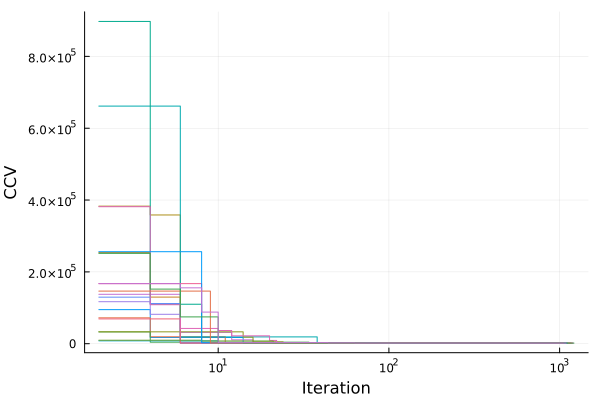

In [597]:
# Plot convergence curve
pl=plot(CCsT[1], xaxis=:log, linetype=:step, label = "", xlabel = "Iteration", ylabel = "CCV")
for i in 2:length(CCsT)
    plot!(CCsT[i], xaxis=:log, linetype=:step, label = "")
end

display(pl)

In [598]:
parfitT = zeros(6, Iters);
for i in 1:Iters
    parfitT[:,i] = best_candidate(FitsT[i]);
end

In [600]:
ppT = mean(parfitT, dims = 2)

6×1 Matrix{Float64}:
     5.6557702599106765
 60161.50186095703
    48.0
    55.0
 48585.34039493208
   658.935473323545

In [540]:
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\FitResults\\resMTRRMMR.jld2", "FitsT",FitsT)
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\FitResults\\resMVectTRRMMR.jld2", 
        "resMMat",parfitT, "CCsT", CCsT)

In [541]:
ppT = mean(JLD2.load("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\FitResults\\resMVectTRRMMR.jld2")["resMMat"], dims = 2);


In [220]:
hcat(mean(JLD2.load("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\FitResults\\resMVectTRRMMR.jld2")["resMMat"], dims = 2),
     std(JLD2.load("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\FitResults\\resMVectTRRMMR.jld2")["resMMat"], dims = 2))

6×2 Matrix{Float64}:
    53.5639  NaN
 15894.6     NaN
    25.4992  NaN
    60.718   NaN
  6310.82    NaN
    22.0358  NaN

In [542]:
ppT = parfitT[:,5]

6-element Vector{Float64}:
    23.256947066223375
 13712.601942730325
    48.0
    55.0
 13959.104405684782
    29.550627220893304

## Plot Results

In [601]:
N=4
tsC2 = dat32mM[:,1]
ts = 0:tsC2[end];
ivss = [dat32mM[1,2], 0, dat32mM[1,4]];
samps = convert.(Int, tsC2);
SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllMMR(ts, vcat(vcat(ppT[1]*N, ppT[2], ppT[3:4], ppT[5].*N, ppT[6]), 0), ivss, samps);


tsC4 = dat128mM[:,1]
ts = 0:tsC4[end];
ivss = [dat128mM[1,2], 0, dat128mM[1,4]];
samps = convert.(Int, tsC4);
SimOnTime2, SimOffTime2, SimAll2  = PyruvateHP_NMR_SolveAllMMR(ts, vcat(vcat(ppT[1]*N, ppT[2], ppT[3:4], ppT[5].*N, ppT[6]), 0), ivss, samps);



([34670.694942714574 0.0 0.0; 8.106639428849934e-27 24092.936502459128 7.997208867439989; … ; 7.6434382733798e-281 25.870809779126123 2.0549871750707935; 1.1524859635368002e-287 23.57830034276257 1.8957595821006443;;;], Any[[-0.0 34670.694942714574 0.0 0.0]], Any[[0.0 34670.694942714574 0.0 0.0; 20.0 8.106639428849934e-27 24092.936502459128 7.997208867439989; … ; 390.0 7.6434382733798e-281 25.870809779126123 2.0549871750707935; 395.0 1.1524859635368002e-287 23.57830034276257 1.8957595821006443]])

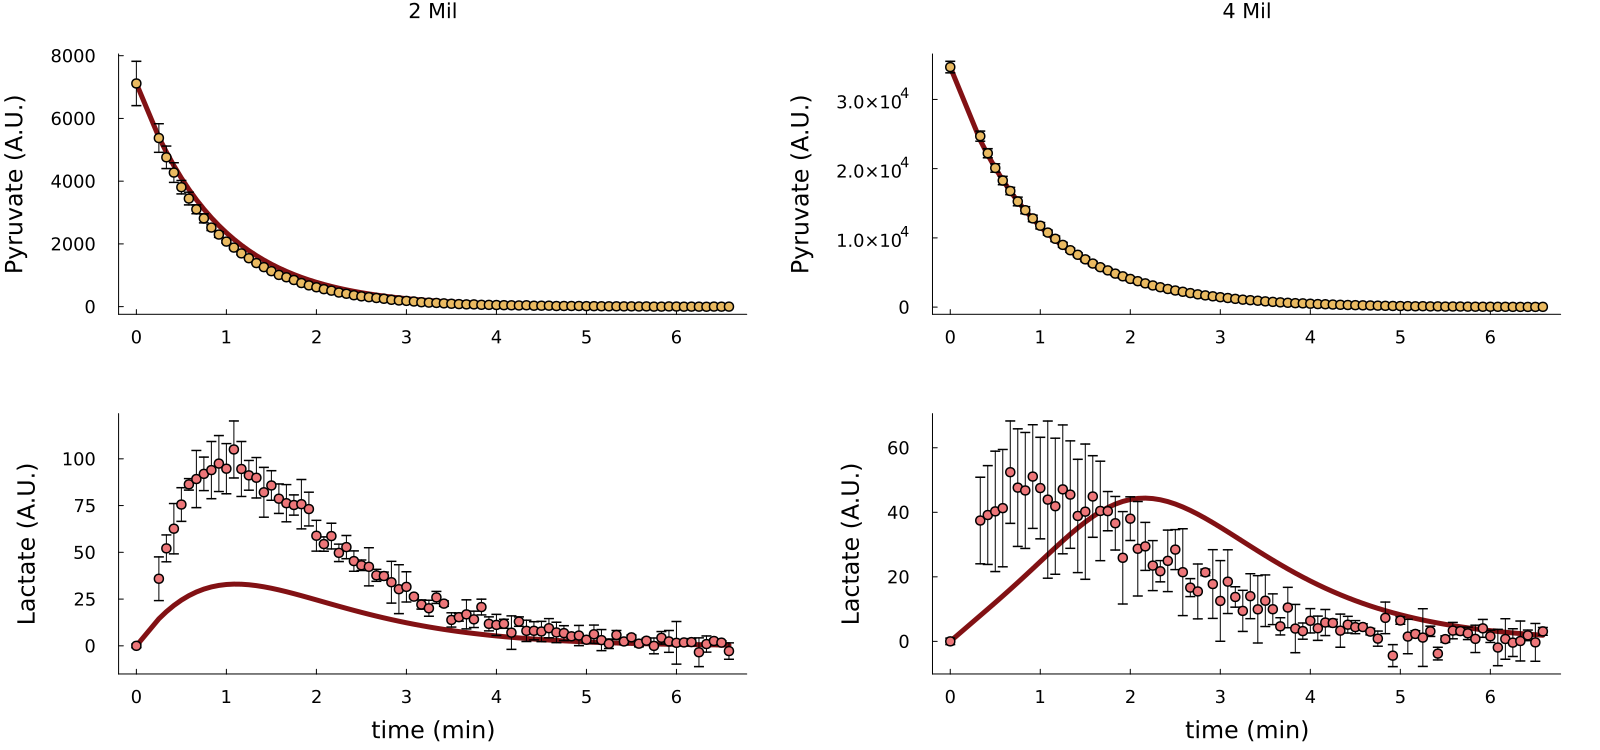

In [602]:
pp1 = plot(tsC2./60, SimOnTime1[:,1,1]+SimOnTime1[:,2,1], linewidth = 5, color = "#821114ff", label = "", title = "2 Mil")
scatter!(tsC2./60, dat32mM[:,2], yerror = dat32mM[:,3], label = "", xlabel="", ylabel = "Pyruvate (A.U.)", grid = false, color="#eaba61ff", markersize=5)

pp2 = plot(tsC2./60, SimOnTime1[:,3,1], linewidth = 5, color = "#821114ff", label = "")
scatter!(tsC2./60, dat32mM[:,4], yerror = dat32mM[:,5], label = "", xlabel="time (min)", ylabel = "Lactate (A.U.)", grid = false, color="#ed7679ff", markersize=5)

P1 = plot(pp1,pp2, layout=(2,1), size = (800,750), margin = 8mm, xguidefontsize=16, yguidefontsize=16, tickfontsize=12)

pp1 = plot(tsC4./60, SimOnTime2[:,1,1]+SimOnTime2[:,2,1], linewidth = 5, color = "#821114ff", label = "", title = "4 Mil")
scatter!(tsC4./60, dat128mM[:,2], yerror = dat128mM[:,3], label = "", xlabel="", ylabel = "Pyruvate (A.U.)", grid = false, color="#eaba61ff", markersize=5)

pp2 = plot(tsC4./60, SimOnTime2[:,3,1], linewidth = 5, color = "#821114ff", label = "")
scatter!(tsC4./60, dat128mM[:,4], yerror = dat128mM[:,5], label = "", xlabel="time (min)", ylabel = "Lactate (A.U.)", grid = false, color="#ed7679ff", markersize=5)

P2 = plot(pp1,pp2, layout=(2,1), size = (800,750), margin = 8mm, xguidefontsize=16, yguidefontsize=16, tickfontsize=12)


pF = plot(P1,P2, layout=(1,2), size = (1600,750))


# savefig("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\Paper\\Figures\\SVGsInit\\PosteriorTestRepress.svg")


display(pF)

In [545]:
maximum(SimOnTime1[:,3,1])

81.5206358740925

In [546]:
maximum(SimOnTime2[:,3,1])

81.91508034664052

In [435]:
ppT

6×1 Matrix{Float64}:
    51.85369504317075
     4.694852502762826
    48.0
    55.0
 96668.97520509061
     0.680510499123047

In [436]:
ivss

3-element Vector{Float64}:
 34670.694942714574
     0.0
     0.0

In [603]:
pyrs = collect(0:40:dat128mM[1,2]*1.2);
lacs = zeros(length(pyrs));


cnt = 1;

for i in pyrs

    try
    N=4
    tsC2 = dat32mM[:,1]
    ts = 0:tsC2[end];
    ivss = [i, 0, dat32mM[1,4]];
    samps = convert.(Int, tsC2);
    SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllMMR(ts, vcat(vcat(ppT[1]*N*1000, ppT[2], ppT[3:4], ppT[5].*N, ppT[6]*0.00001), 0), ivss, samps);

    lacs[cnt] = maximum(SimOnTime1[:,3]);
    catch

    end
    cnt += 1;

end

plot(pyrs, lacs)


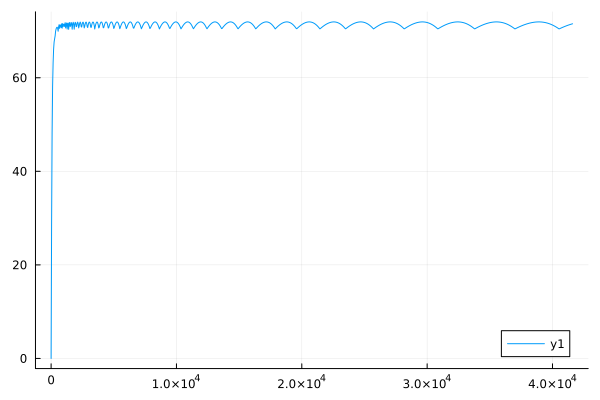

In [604]:
plot(pyrs, lacs)
# scatter!([dat32mM[1,2]], [maximum(dat32mM[:,4])])
# scatter!([dat128mM[1,2]], [maximum(dat128mM[:,4])])



In [305]:
(dat32mM[:,4])

78-element Vector{Float64}:
  0.0
 35.8707
 52.1106
 62.6346
 75.55833333333332
 86.3455
 89.19013333333332
 91.96116666666667
 93.97180000000002
 97.46533333333333
  ⋮
  2.3524166666666666
  1.6061466666666664
  1.8086746666666667
  1.9932299999999998
 -3.4320000000000004
  0.9518029333333334
  2.5859433333333333
  1.7071833333333333
 -2.808711

In [278]:
ppT = pp

6-element Vector{Float64}:
  12.0
 640.0
  48.0
  55.0
   0.00044
  10.0

# Big Repression

In [605]:
# Michaelis Menten Repression

function PyruvateHP_CellsMMR!(du, u, p, t)

    Pout, Php, Xhp = u;
    Vm, Km, T1_X, T1_P, kin, Ki1, Ki2, kr = p;


    du[1] = dPout = - (Pout*kin) - (Pout/T1_P)
    du[2] = dPhp = (Pout*kin) - ((Vm*(1+Php/Ki2*kr)*Php) / (Php*(1+Php/Ki2)+Km*(1+Php/Ki1))) - (Php/T1_P)
    du[3] = dXhp = ((Vm*(1+Php/Ki2*kr)*Php) / (Php*(1+Php/Ki2)+Km*(1+Php/Ki1))) - (Xhp/T1_X)
    


end

PyruvateHP_CellsMMR! (generic function with 1 method)

In [606]:
function PyruvateHP_NMR_SolveAllMMR(ts, pD, ivss, samps)

    if length(size(pD)) == 1
        pD = reshape(pD,size(pD)[1],1);
    end

    if size(pD)[2] != 7     
        pD = pD';
    end

    if length(ivss)/3 > 1
        if size(ivss)[2] != 3
            ivss = ivss';
        end
    end

    AllSolTest = zeros(length(samps), 3, length(pD[:,1])); # Simulation of the system observed
    AllSolTest_Off = Array{Any,1}(undef,length(pD[:,1])); # Simulation of the system before we obvserve it (considering time offset). First column is the time vector
    AllSolTest_Tog = Array{Any,1}(undef,length(pD[:,1])); # Previous two together. First column is the time vector. 


    
    for drawInd in collect(1:length(pD[:,1]))
        
        p = pD[drawInd,1:end-1];
        tau = pD[drawInd,end];
        
        if length(ivss)/3 > 1
            ivss2 = ivss[drawInd,:];
        else
            ivss2 = ivss;
        end
    
        # Account for the time offset
    
        
            prob_off = ODEProblem(PyruvateHP_CellsMMR!,ivss2,(-tau, 0),p);
            part1_off = DifferentialEquations.solve(prob_off, CVODE_BDF(),reltol=1.0e-9,abstol=1.0e-9);
        
            ivss2 = part1_off.u[end];
        
            prob = ODEProblem(PyruvateHP_CellsMMR!,ivss2,(ts[1], ts[end]),p);
            part1 = DifferentialEquations.solve(prob, CVODE_BDF(),reltol=1.0e-9,abstol=1.0e-9,saveat=1);
        
        
        AllSolTest[:,:,drawInd]
    
        tmp = zeros(length(part1_off.u), 3);
    
        
        

        for j in 1:3
            AllSolTest[:,j,drawInd] = [part1.u[i][j] for i in 1:length(part1.u)][samps.+1];
            tmp[:,j] = [part1_off.u[i][j] for i in 1:length(part1_off.u)];
        end

        AllSolTest_Off[drawInd] = hcat(part1_off.t, tmp);
        AllSolTest_Tog[drawInd] = vcat(AllSolTest_Off[drawInd][1:end-1, :], hcat(samps, AllSolTest[:,:,drawInd]));
        
        
        
    
    end

    return AllSolTest, AllSolTest_Off, AllSolTest_Tog

end

PyruvateHP_NMR_SolveAllMMR (generic function with 1 method)

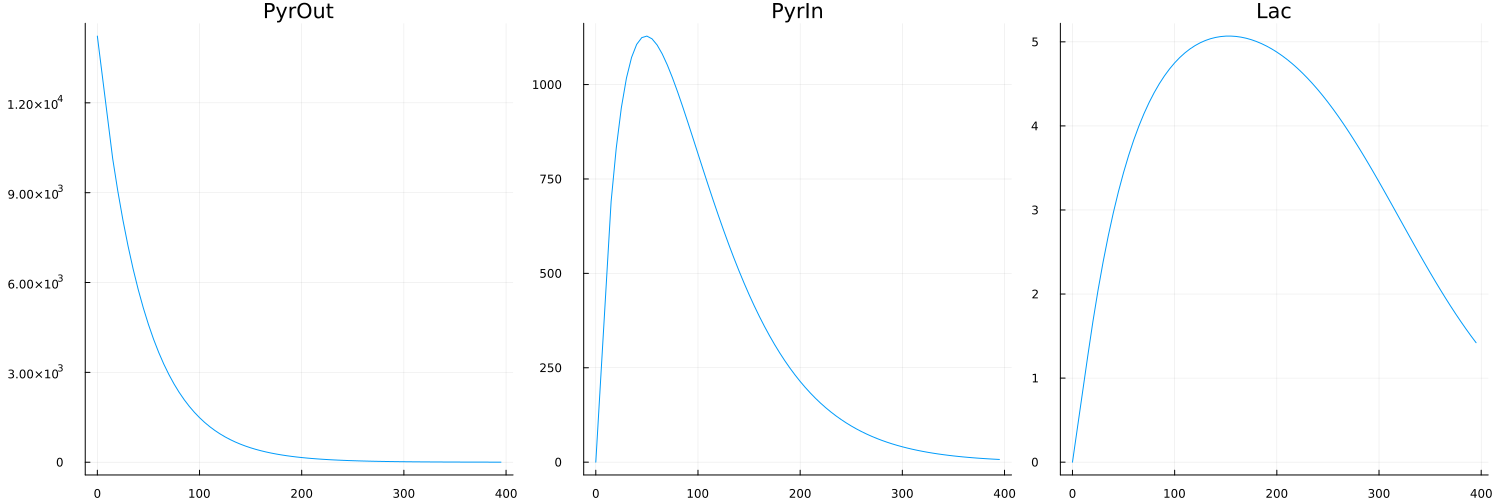

In [657]:
N = 4;

tsC2 = dat32mM[:,1]
ts = 0:tsC2[end];
ivss = [dat32mM[1,2],0, dat32mM[1,4]];
samps = convert.(Int, tsC2);
pp = [12, 640, 48, 55, 0.0044, 0.0001, 0.01, 0.0101] #Vm, Km, T1_X, T1_P, kin, Ki1, Ki2, kr = p;
SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllMMR(ts, vcat(vcat(pp), 0), ivss, samps);


p1 = plot(tsC2, SimOnTime1[:,1,:], label = "", title = "PyrOut")
p2 = plot(tsC2, SimOnTime1[:,2,:], label = "", title = "PyrIn")
p3 = plot(tsC2, SimOnTime1[:,3,:], label = "", title = "Lac")

plot(p1, p2, p3, size=(1500,500), layout = (1,3))

In [71]:
function ObjectFunctMEMMR(p)

    N = 4;

    # Define parameter vectors for each amount of cells (last parameter is a time delay, not used in here)
    pD2 = vcat(p, 0);

    # Define time vector
    t2cor = dat32mM[:,1];
    t4cor = dat128mM[:,1];

    # Define equaly-spaced time vector
    ts1 = collect(0:t2cor[end]);
    ts2 = collect(0:t4cor[end]);

    # Define initial value for simulation (use of experimental mean)
    ivss1 = [dat32mM[1,2], 0, dat32mM[1,4]];
    ivss2 = [dat128mM[1,2], 0, dat128mM[1,4]];

    # Convert sampling vector to integer to extract correct elements from simulation
    samps1 = convert.(Int, t2cor);
    samps2 = convert.(Int, t4cor);

    # Simulate
    SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllMMR(ts1, pD2, ivss1, samps1);
    SimOnTime2, SimOffTime2, SimAll2  = PyruvateHP_NMR_SolveAllMMR(ts2, pD2, ivss2, samps2);

    # Use of log-likelihood as cost funtion: J_llk = sum(-1/2 * (log(2*pi) + log(std^2) + (sim-dat)^2/std^2))
    mm11 = sum((-1/2) .* (log(2*pi) .+ log.(dat32mM[:,3].^2) .+ (((SimOnTime1[:,1]+SimOnTime1[:,2]) .- dat32mM[:,2]).^2)./(dat32mM[:,3].^2)));
    mm12 = sum((-1/2) .* (log(2*pi) .+ log.(dat128mM[:,3].^2) .+ (((SimOnTime2[:,1]+SimOnTime2[:,2]) .- dat128mM[:,2]).^2)./(dat128mM[:,3].^2)));

    mm21 = sum((-1/2) .* (log(2*pi) .+ log.(dat32mM[:,5].^2) .+ ((SimOnTime1[:,3] .- dat32mM[:,4]).^2)./(dat32mM[:,5].^2)));
    mm22 = sum((-1/2) .* (log(2*pi) .+ log.(dat128mM[:,5].^2) .+ ((SimOnTime2[:,3] .- dat128mM[:,4]).^2)./(dat128mM[:,5].^2)));


    obj = (mm21+mm22)*(mm11+mm12);
    # obj = -(mm21+mm22);

    
    return(obj)

end

ObjectFunctMEMMR (generic function with 1 method)

In [619]:
p = [12, 640, 48, 55, 0.0044, 0.0001, 0.0001, 0.11];

ObjectFunctMEMMR(p)

2705.4834122809316

In [620]:
T1ss = vcat(datT1[1:5,2], datT1[7:11,2]);

In [621]:
Iters = 20;
CCsT = Array{Any}(undef,Iters);
FitsT = Array{Any}(undef,Iters);

In [638]:
Random.seed!(4879564)
plan = randomLHC(Iters,8)
initguessT = scaleLHC(plan,[(1e-300, 1e2), (1e-300, 1e5), (48, 48), (55, 55), (1e-300, 1e2), (1e-300, 1e2), (1e-100, 1e2), (1e-300, 1e2)])

20×8 Matrix{Float64}:
  73.6842    100000.0       48.0  55.0  …    5.26316    15.7895     68.4211
  31.5789     78947.4       48.0  55.0      21.0526     84.2105      1.0e-300
  68.4211     73684.2       48.0  55.0      26.3158     36.8421     36.8421
  78.9474      5263.16      48.0  55.0      15.7895     47.3684     21.0526
  47.3684     47368.4       48.0  55.0      36.8421     10.5263     42.1053
  42.1053     36842.1       48.0  55.0  …   31.5789     94.7368     57.8947
 100.0        89473.7       48.0  55.0      94.7368     26.3158     63.1579
  63.1579     31578.9       48.0  55.0      10.5263     73.6842     78.9474
   5.26316    94736.8       48.0  55.0      52.6316     78.9474     73.6842
  10.5263     42105.3       48.0  55.0      57.8947    100.0        47.3684
  15.7895     26315.8       48.0  55.0  …   47.3684     21.0526     84.2105
   1.0e-300       1.0e-300  48.0  55.0      73.6842     57.8947     89.4737
  84.2105     57894.7       48.0  55.0      68.4211     42.1053 

In [625]:
Threads.nthreads()

20

In [639]:
initguessT[15,:]

8-element Vector{Float64}:
    36.8421052631579
 63157.89473684211
    48.0
    55.0
    94.73684210526316
    42.10526315789474
     1.0e-100
    94.73684210526316

In [664]:
Threads.@threads for i in 1:Iters
    fitness_progress_history = Array{Tuple{Int, Float64},1}()
    callback = oc -> push!(fitness_progress_history, (num_func_evals(oc), best_fitness(oc)))

    resM = bboptimize(ObjectFunctMEMMR, initguessT[i,:]; SearchRange = [(1e-300, 1e2), (1e-300, 1e5), (48, 48), (55, 55), (1e-300, 1e2), (1e-300, 1e2), (1e-300, 1e2), (1e-300, 1e2)], 
            MaxTime = 60*0.6, method = :adaptive_de_rand_1_bin, 
            CallbackFunction = callback, CallbackInterval = 0.0)

    CCsT[i] = fitness_progress_history;
    FitsT[i] = resM;
end

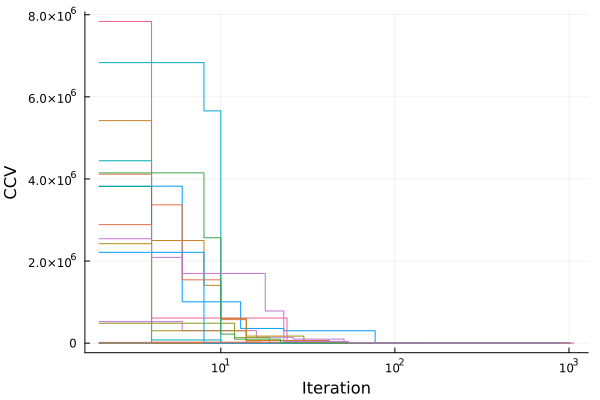

In [665]:
# Plot convergence curve
pl=plot(CCsT[1], xaxis=:log, linetype=:step, label = "", xlabel = "Iteration", ylabel = "CCV")
for i in 2:length(CCsT)
    plot!(CCsT[i], xaxis=:log, linetype=:step, label = "")
end

display(pl)

In [666]:
parfitT = zeros(8, Iters);
for i in 1:Iters
    parfitT[:,i] = best_candidate(FitsT[i]);
end

In [667]:
ppT = mean(parfitT, dims = 2)

8×1 Matrix{Float64}:
    24.656974973667488
 41857.031605562355
    48.0
    55.0
    41.68147981494051
    55.345425940721974
    38.7076230266141
     7.450327779227149

In [668]:
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\FitResults\\resMTRRMMR.jld2", "FitsT",FitsT)
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\FitResults\\resMVectTRRMMR.jld2", 
        "resMMat",parfitT, "CCsT", CCsT)

In [669]:
ppT = mean(JLD2.load("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\FitResults\\resMVectTRRMMR.jld2")["resMMat"], dims = 2);


In [ ]:
hcat(mean(JLD2.load("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\FitResults\\resMVectTRRMMR.jld2")["resMMat"], dims = 2),
     std(JLD2.load("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\FitResults\\resMVectTRRMMR.jld2")["resMMat"], dims = 2))

6×2 Matrix{Float64}:
    53.5639  NaN
 15894.6     NaN
    25.4992  NaN
    60.718   NaN
  6310.82    NaN
    22.0358  NaN

## Plot Results

In [670]:
N=4
tsC2 = dat32mM[:,1]
ts = 0:tsC2[end];
ivss = [dat32mM[1,2], 0, dat32mM[1,4]];
samps = convert.(Int, tsC2);
SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllMMR(ts, vcat(vcat(ppT), 0), ivss, samps);


tsC4 = dat128mM[:,1]
ts = 0:tsC4[end];
ivss = [dat128mM[1,2], 0, dat128mM[1,4]];
samps = convert.(Int, tsC4);
SimOnTime2, SimOffTime2, SimAll2  = PyruvateHP_NMR_SolveAllMMR(ts, vcat(vcat(ppT), 0), ivss, samps);



([34670.694942714574 0.0 0.0; 6.700501464796822e-19 22607.692898429308 1455.4773408430776; … ; -5.0086049221111474e-77 5.8689087121757595 11.7911483141292; -2.2830132112138112e-77 5.329220975339159 10.654196598839238;;;], Any[[-0.0 34670.694942714574 0.0 0.0]], Any[[0.0 34670.694942714574 0.0 0.0; 20.0 6.700501464796822e-19 22607.692898429308 1455.4773408430776; … ; 390.0 -5.0086049221111474e-77 5.8689087121757595 11.7911483141292; 395.0 -2.2830132112138112e-77 5.329220975339159 10.654196598839238]])

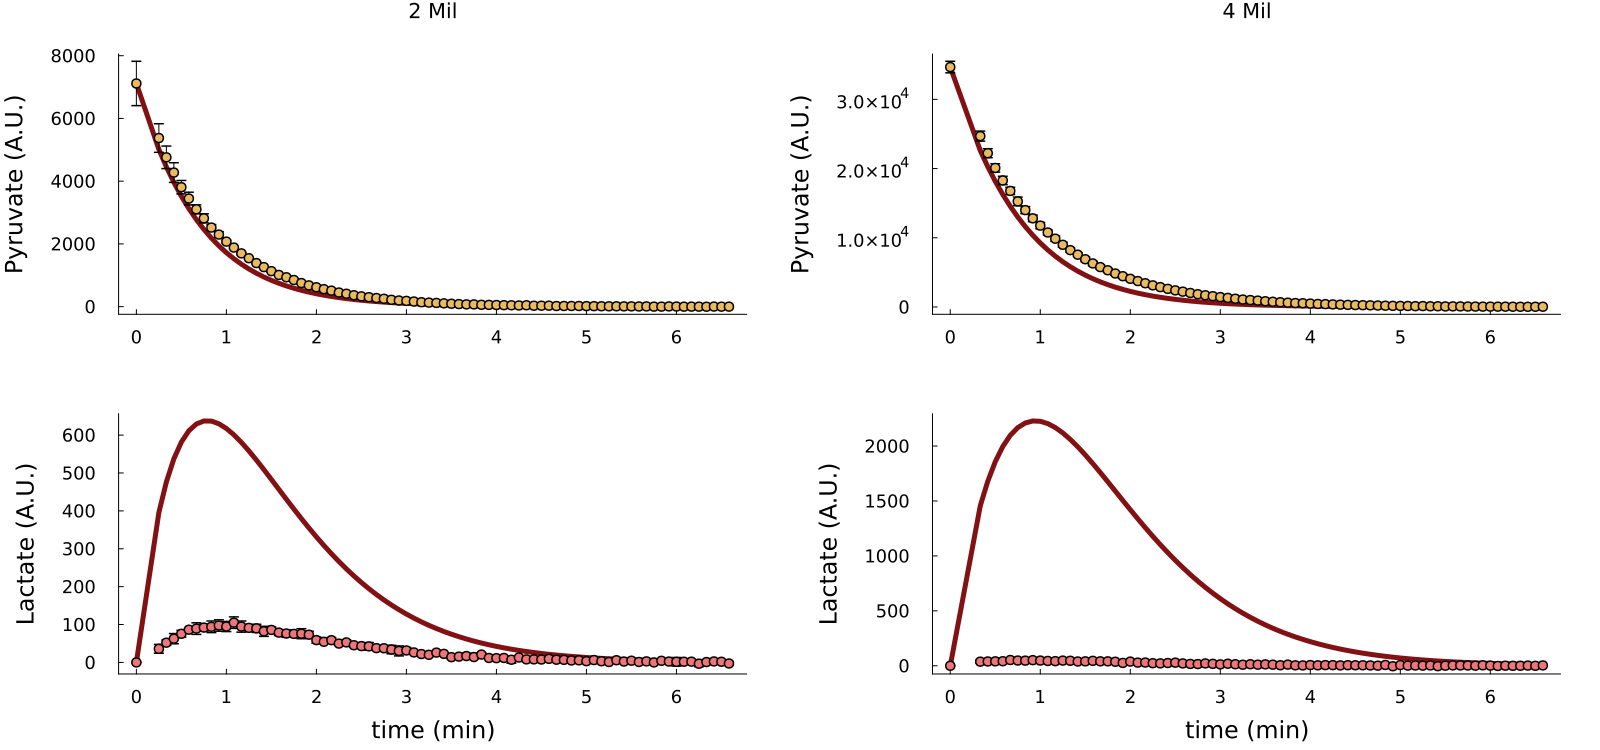

In [671]:
pp1 = plot(tsC2./60, SimOnTime1[:,1,1]+SimOnTime1[:,2,1], linewidth = 5, color = "#821114ff", label = "", title = "2 Mil")
scatter!(tsC2./60, dat32mM[:,2], yerror = dat32mM[:,3], label = "", xlabel="", ylabel = "Pyruvate (A.U.)", grid = false, color="#eaba61ff", markersize=5)

pp2 = plot(tsC2./60, SimOnTime1[:,3,1], linewidth = 5, color = "#821114ff", label = "")
scatter!(tsC2./60, dat32mM[:,4], yerror = dat32mM[:,5], label = "", xlabel="time (min)", ylabel = "Lactate (A.U.)", grid = false, color="#ed7679ff", markersize=5)

P1 = plot(pp1,pp2, layout=(2,1), size = (800,750), margin = 8mm, xguidefontsize=16, yguidefontsize=16, tickfontsize=12)

pp1 = plot(tsC4./60, SimOnTime2[:,1,1]+SimOnTime2[:,2,1], linewidth = 5, color = "#821114ff", label = "", title = "4 Mil")
scatter!(tsC4./60, dat128mM[:,2], yerror = dat128mM[:,3], label = "", xlabel="", ylabel = "Pyruvate (A.U.)", grid = false, color="#eaba61ff", markersize=5)

pp2 = plot(tsC4./60, SimOnTime2[:,3,1], linewidth = 5, color = "#821114ff", label = "")
scatter!(tsC4./60, dat128mM[:,4], yerror = dat128mM[:,5], label = "", xlabel="time (min)", ylabel = "Lactate (A.U.)", grid = false, color="#ed7679ff", markersize=5)

P2 = plot(pp1,pp2, layout=(2,1), size = (800,750), margin = 8mm, xguidefontsize=16, yguidefontsize=16, tickfontsize=12)


pF = plot(P1,P2, layout=(1,2), size = (1600,750))


# savefig("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\Paper\\Figures\\SVGsInit\\PosteriorTestRepress.svg")


display(pF)

In [672]:
pyrs = collect(0:40:dat128mM[1,2]*1.2);
lacs = zeros(length(pyrs));


cnt = 1;

for i in pyrs

    try
    N=4
    tsC2 = dat32mM[:,1]
    ts = 0:tsC2[end];
    ivss = [i, 0, dat32mM[1,4]];
    samps = convert.(Int, tsC2);
    SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllMMR(ts, vcat(vcat(ppT), 0), ivss, samps);

    lacs[cnt] = maximum(SimOnTime1[:,3]);
    catch

    end
    cnt += 1;

end

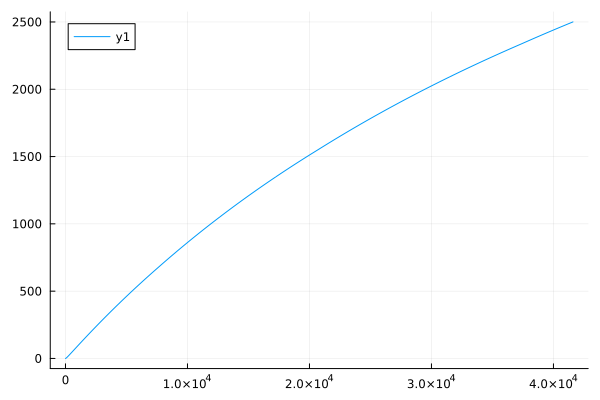

In [673]:
plot(pyrs, lacs)
# scatter!([dat32mM[1,2]], [maximum(dat32mM[:,4])])
# scatter!([dat128mM[1,2]], [maximum(dat128mM[:,4])])



In [ ]:
(dat32mM[:,4])

78-element Vector{Float64}:
  0.0
 35.8707
 52.1106
 62.6346
 75.55833333333332
 86.3455
 89.19013333333332
 91.96116666666667
 93.97180000000002
 97.46533333333333
  ⋮
  2.3524166666666666
  1.6061466666666664
  1.8086746666666667
  1.9932299999999998
 -3.4320000000000004
  0.9518029333333334
  2.5859433333333333
  1.7071833333333333
 -2.808711

# Accurate Repression

In [19]:
# Michaelis Menten Repression

function PyruvateHP_CellsMMR!(du, u, p, t)

    Pout, Php, Xhp = u;
    T1_X, T1_P, kin, Vm, Va, Vi, Km, Ki = p;


    du[1] = dPout = - (Pout*kin) - (Pout/T1_P)
    du[2] = dPhp = (Pout*kin) - ((Va*Php^2)-(Vm*Php)-(Vi*Php^2))/(Km+Php+((Php^2)/Ki)) - (Php/T1_P)
    du[3] = dXhp = ((Vm*Php)/(Km+Php+((Php^2)/Ki))) - (Xhp/T1_X)
    


    # du[2] = dPhp = (Pout*kin) - ((Vm*Php)/(Km+Php+((Php^2)/Ki))) - (Php/T1_P)
    # du[3] = dXhp = ((Vm*Php)/(Km+Php+((Php^2)/Ki))) - (Xhp/T1_X)


    # du[2] = dPhp = (Pout*kin) - ((Vm)/((1+(Km/Php))*(1+(Php/Ki)))) - (Php/T1_P)
    # du[3] = dXhp = ((Vm)/((1+(Km/Php))*(1+(Php/Ki)))) - (Xhp/T1_X)

    # du[2] = dPhp = (Pout*kin) - ((Vm*Php)/(Km*(1+(Php/Ki))+(Php))) - (Php/T1_P)
    # du[3] = dXhp = ((Vm*Php)/(Km*(1+(Php/Ki))+(Php))) - (Xhp/T1_X)

end

PyruvateHP_CellsMMR! (generic function with 1 method)

In [20]:
function PyruvateHP_NMR_SolveAllMMR(ts, pD, ivss, samps)

    if length(size(pD)) == 1
        pD = reshape(pD,size(pD)[1],1);
    end

    if size(pD)[2] != 9     
        pD = pD';
    end

    if length(ivss)/3 > 1
        if size(ivss)[2] != 3
            ivss = ivss';
        end
    end

    AllSolTest = zeros(length(samps), 3, length(pD[:,1])); # Simulation of the system observed
    AllSolTest_Off = Array{Any,1}(undef,length(pD[:,1])); # Simulation of the system before we obvserve it (considering time offset). First column is the time vector
    AllSolTest_Tog = Array{Any,1}(undef,length(pD[:,1])); # Previous two together. First column is the time vector. 


    
    for drawInd in collect(1:length(pD[:,1]))
        
        p = pD[drawInd,1:end-1];
        tau = pD[drawInd,end];
        
        if length(ivss)/3 > 1
            ivss2 = ivss[drawInd,:];
        else
            ivss2 = ivss;
        end
    
        # Account for the time offset
    
        
            prob_off = ODEProblem(PyruvateHP_CellsMMR!,ivss2,(-tau, 0),p);
            part1_off = DifferentialEquations.solve(prob_off, CVODE_BDF(),reltol=1.0e-9,abstol=1.0e-9);
        
            ivss2 = part1_off.u[end];
        
            prob = ODEProblem(PyruvateHP_CellsMMR!,ivss2,(ts[1], ts[end]),p);
            part1 = DifferentialEquations.solve(prob, CVODE_BDF(),reltol=1.0e-9,abstol=1.0e-9,saveat=1);
        
        
        AllSolTest[:,:,drawInd]
    
        tmp = zeros(length(part1_off.u), 3);
    
        
        

        for j in 1:3
            AllSolTest[:,j,drawInd] = [part1.u[i][j] for i in 1:length(part1.u)][samps.+1];
            tmp[:,j] = [part1_off.u[i][j] for i in 1:length(part1_off.u)];
        end

        AllSolTest_Off[drawInd] = hcat(part1_off.t, tmp);
        AllSolTest_Tog[drawInd] = vcat(AllSolTest_Off[drawInd][1:end-1, :], hcat(samps, AllSolTest[:,:,drawInd]));
        
        
        
    
    end

    return AllSolTest, AllSolTest_Off, AllSolTest_Tog

end

PyruvateHP_NMR_SolveAllMMR (generic function with 1 method)

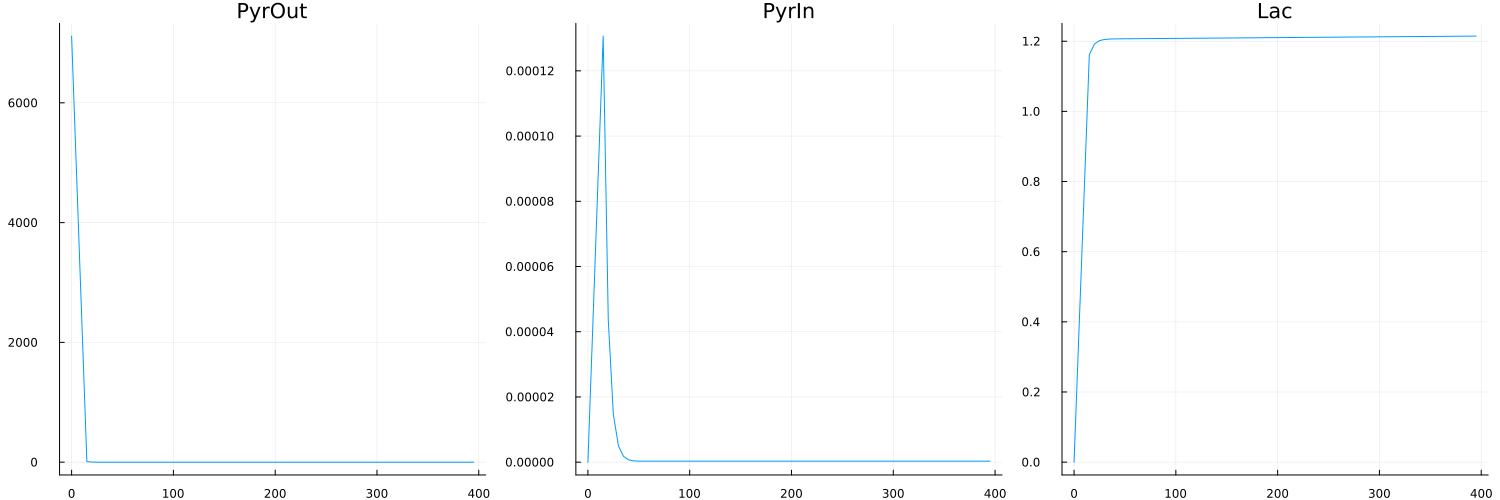

In [51]:
N = 4;

tsC2 = dat32mM[:,1]
ts = 0:tsC2[end];
ivss = [dat32mM[1,2],0, dat32mM[1,4]];
samps = convert.(Int, tsC2);
pp = [48*100000, 55*100000, 0.44, 6000, 2e10, 20e1, 8e1, 2e4] #T1_X, T1_P, kin, Vm, Va, Vi, Km, Ki
SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllMMR(ts, vcat(vcat(pp), 0), ivss, samps);


p1 = plot(tsC2, SimOnTime1[:,1,:], label = "", title = "PyrOut")
p2 = plot(tsC2, SimOnTime1[:,2,:], label = "", title = "PyrIn")
p3 = plot(tsC2, SimOnTime1[:,3,:], label = "", title = "Lac")

plot(p1, p2, p3, size=(1500,500), layout = (1,3))

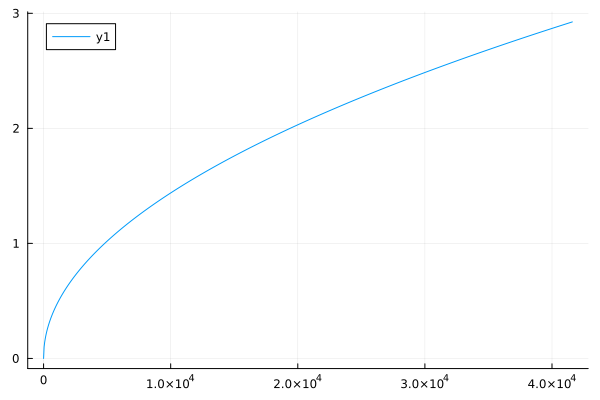

In [52]:
pyrs = collect(0:40:dat128mM[1,2]*1.2);
lacs = zeros(length(pyrs));

# pp = [1e5, 2e9, 48, 55, 1000000, 2e-7]
cnt = 1;

for i in pyrs

    try
    N=4
    tsC2 = dat32mM[:,1]
    ts = 0:tsC2[end];
    ivss = [i, 0, dat32mM[1,4]];
    samps = convert.(Int, tsC2);
    SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllMMR(ts, vcat(vcat(pp), 0), ivss, samps);

    lacs[cnt] = maximum(SimOnTime1[:,3]);
    catch

    end
    cnt += 1;

end

plot(pyrs, lacs)


In [58]:
p = [48*100000, 55*100000, 0.44, 6000, 2e10, 20e1, 8e1, 2e4];

ObjectFunctMEMMR(p)

2996.8736576887377

In [59]:
T1ss = vcat(datT1[1:5,2], datT1[7:11,2]);

In [60]:
Iters = 20;
CCsT = Array{Any}(undef,Iters);
FitsT = Array{Any}(undef,Iters);

In [61]:
Random.seed!(4879564)
plan = randomLHC(Iters,8)
initguessT = scaleLHC(plan,[(48, 48), (55, 55), (1e-300, 1e2), (1e-300, 1e5), (1e-300, 1e2), (1e-300, 1e2), (1e-100, 1e2), (1e-300, 1e2)])

20×8 Matrix{Float64}:
 48.0  55.0   57.8947     78947.4       …    5.26316    15.7895     68.4211
 48.0  55.0    5.26316    42105.3           21.0526     84.2105      1.0e-300
 48.0  55.0   10.5263         1.0e-300      26.3158     36.8421     36.8421
 48.0  55.0   84.2105     10526.3           15.7895     47.3684     21.0526
 48.0  55.0   42.1053     57894.7           36.8421     10.5263     42.1053
 48.0  55.0   26.3158     94736.8       …   31.5789     94.7368     57.8947
 48.0  55.0   78.9474     73684.2           94.7368     26.3158     63.1579
 48.0  55.0   73.6842     84210.5           10.5263     73.6842     78.9474
 48.0  55.0    1.0e-300   52631.6           52.6316     78.9474     73.6842
 48.0  55.0   47.3684     21052.6           57.8947    100.0        47.3684
 48.0  55.0   89.4737     36842.1       …   47.3684     21.0526     84.2105
 48.0  55.0   21.0526     15789.5           73.6842     57.8947     89.4737
 48.0  55.0  100.0        26315.8           68.4211     42.1053 

In [62]:
Threads.nthreads()

20

In [63]:
initguessT[15,:]

8-element Vector{Float64}:
    48.0
    55.0
    63.1578947368421
 31578.947368421053
    94.73684210526316
    42.10526315789474
     1.0e-100
    94.73684210526316

In [72]:
Threads.@threads for i in 1:Iters
    fitness_progress_history = Array{Tuple{Int, Float64},1}()
    callback = oc -> push!(fitness_progress_history, (num_func_evals(oc), best_fitness(oc)))

    resM = bboptimize(ObjectFunctMEMMR, initguessT[i,:]; SearchRange = [(48, 48), (55, 55), (1e-300, 1e2), (1e-300, 1e5), (1e-300, 1e2), (1e-300, 1e2), (1e-300, 1e2), (1e-300, 1e2)], 
            MaxTime = 60*0.4, method = :adaptive_de_rand_1_bin, 
            CallbackFunction = callback, CallbackInterval = 0.0)

    CCsT[i] = fitness_progress_history;
    FitsT[i] = resM;
end

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDif

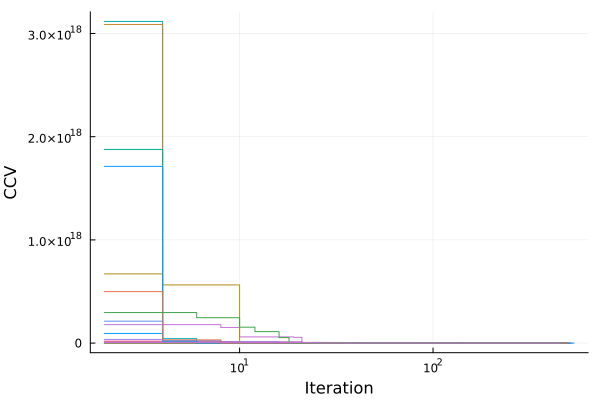

In [73]:
# Plot convergence curve
pl=plot(CCsT[1], xaxis=:log, linetype=:step, label = "", xlabel = "Iteration", ylabel = "CCV")
for i in 2:length(CCsT)
    plot!(CCsT[i], xaxis=:log, linetype=:step, label = "")
end

display(pl)

In [74]:
parfitT = zeros(8, Iters);
for i in 1:Iters
    parfitT[:,i] = best_candidate(FitsT[i]);
end

In [77]:
ppT = mean(parfitT, dims = 2)

8×1 Matrix{Float64}:
    48.0
    55.0
    46.862955001312365
 14980.461475507338
    61.72868475581282
    39.942463913973086
    47.303310451524496
    24.059275734613614

In [ ]:
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\FitResults\\resMTRRMMR.jld2", "FitsT",FitsT)
JLD2.save("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\FitResults\\resMVectTRRMMR.jld2", 
        "resMMat",parfitT, "CCsT", CCsT)

In [ ]:
ppT = mean(JLD2.load("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\FitResults\\resMVectTRRMMR.jld2")["resMMat"], dims = 2);


In [ ]:
hcat(mean(JLD2.load("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\FitResults\\resMVectTRRMMR.jld2")["resMMat"], dims = 2),
     std(JLD2.load("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\DataProcessingInference\\InitalParameterFitPriorDef\\FitResults\\resMVectTRRMMR.jld2")["resMMat"], dims = 2))

6×2 Matrix{Float64}:
    53.5639  NaN
 15894.6     NaN
    25.4992  NaN
    60.718   NaN
  6310.82    NaN
    22.0358  NaN

## Plot Results

In [78]:
N=4
tsC2 = dat32mM[:,1]
ts = 0:tsC2[end];
ivss = [dat32mM[1,2], 0, dat32mM[1,4]];
samps = convert.(Int, tsC2);
SimOnTime1, SimOffTime1, SimAll1  = PyruvateHP_NMR_SolveAllMMR(ts, vcat(vcat(ppT), 0), ivss, samps);


tsC4 = dat128mM[:,1]
ts = 0:tsC4[end];
ivss = [dat128mM[1,2], 0, dat128mM[1,4]];
samps = convert.(Int, tsC4);
SimOnTime2, SimOffTime2, SimAll2  = PyruvateHP_NMR_SolveAllMMR(ts, vcat(vcat(ppT), 0), ivss, samps);



([34670.694942714574 0.0 0.0; -2.4673474783221413e-21 15588.367041988153 260.8727170770518; … ; -6.483710341768485e-109 671.376702784389 24798.443273778477; 1.8481109233735455e-109 671.3767027843888 24800.195466751455;;;], Any[[-0.0 34670.694942714574 0.0 0.0]], Any[[0.0 34670.694942714574 0.0 0.0; 20.0 -2.4673474783221413e-21 15588.367041988153 260.8727170770518; … ; 390.0 -6.483710341768485e-109 671.376702784389 24798.443273778477; 395.0 1.8481109233735455e-109 671.3767027843888 24800.195466751455]])

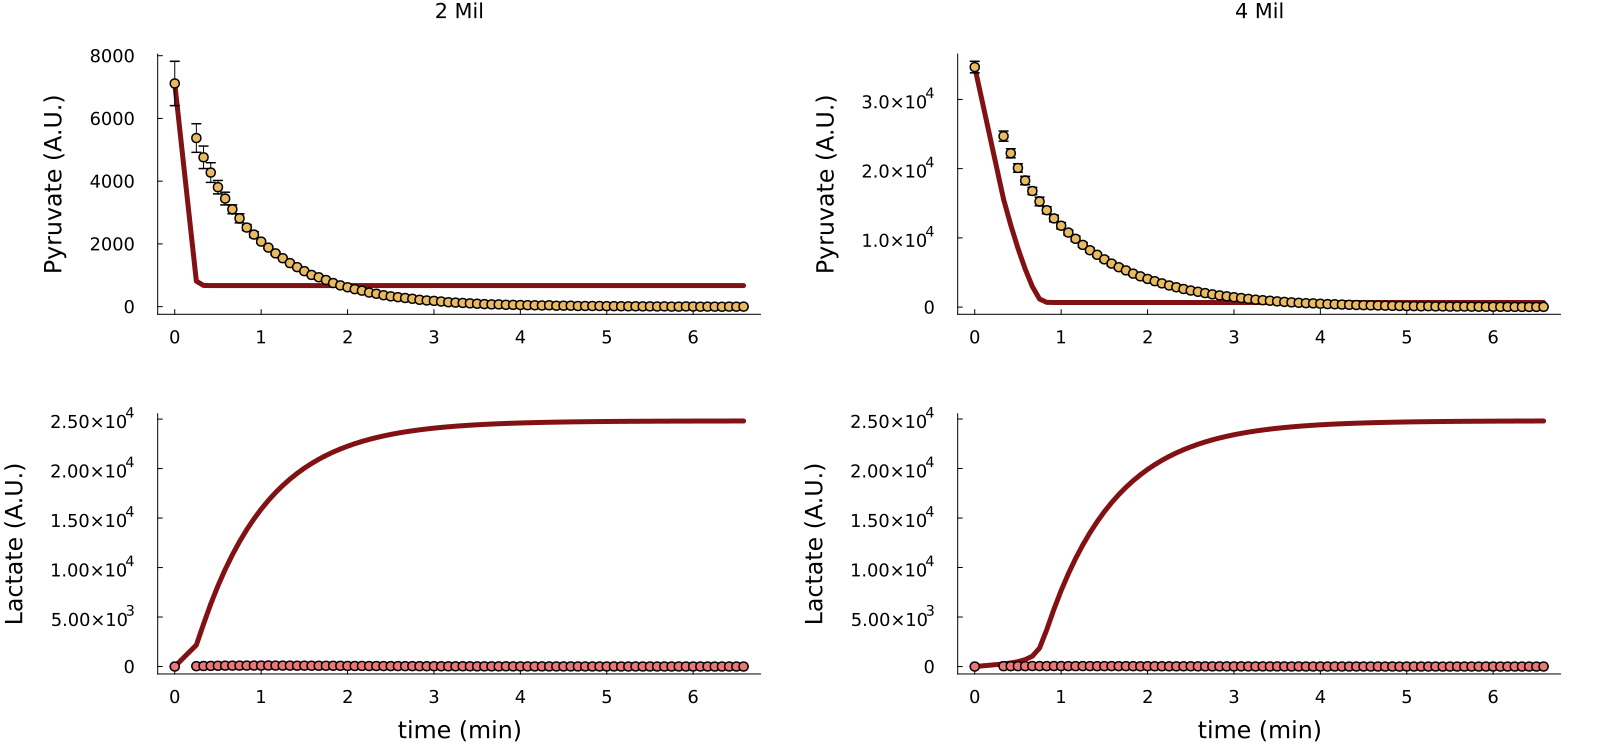

In [80]:
pp1 = plot(tsC2./60, SimOnTime1[:,1,1]+SimOnTime1[:,2,1], linewidth = 5, color = "#821114ff", label = "", title = "2 Mil")
scatter!(tsC2./60, dat32mM[:,2], yerror = dat32mM[:,3], label = "", xlabel="", ylabel = "Pyruvate (A.U.)", grid = false, color="#eaba61ff", markersize=5)

pp2 = plot(tsC2./60, SimOnTime1[:,3,1], linewidth = 5, color = "#821114ff", label = "")
scatter!(tsC2./60, dat32mM[:,4], yerror = dat32mM[:,5], label = "", xlabel="time (min)", ylabel = "Lactate (A.U.)", grid = false, color="#ed7679ff", markersize=5)

P1 = plot(pp1,pp2, layout=(2,1), size = (800,750), margin = 8mm, xguidefontsize=16, yguidefontsize=16, tickfontsize=12)

pp1 = plot(tsC4./60, SimOnTime2[:,1,1]+SimOnTime2[:,2,1], linewidth = 5, color = "#821114ff", label = "", title = "4 Mil")
scatter!(tsC4./60, dat128mM[:,2], yerror = dat128mM[:,3], label = "", xlabel="", ylabel = "Pyruvate (A.U.)", grid = false, color="#eaba61ff", markersize=5)

pp2 = plot(tsC4./60, SimOnTime2[:,3,1], linewidth = 5, color = "#821114ff", label = "")
scatter!(tsC4./60, dat128mM[:,4], yerror = dat128mM[:,5], label = "", xlabel="time (min)", ylabel = "Lactate (A.U.)", grid = false, color="#ed7679ff", markersize=5)

P2 = plot(pp1,pp2, layout=(2,1), size = (800,750), margin = 8mm, xguidefontsize=16, yguidefontsize=16, tickfontsize=12)


pF = plot(P1,P2, layout=(1,2), size = (1600,750))


# savefig("C:\\IBECPostDocDrive\\2024_01_16_NCvsKR\\Paper\\Figures\\SVGsInit\\PosteriorTestRepress.svg")


display(pF)